# Tutorial: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

In [1]:
from time import time
import matplotlib.pyplot as plt
import numpy as np 

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/jordanprosky/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jordanprosky/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load the data

In [3]:
print('Loading Data')
people = fetch_lfw_people(
    './faces', min_faces_per_person=70, resize=0.4)
print('Done!')

Loading Data
Done!


In [4]:
#Find out how many faces we have, and
#the size of each picture from.
n_samples, h, w = people.images.shape
 
X = people.data
n_features = X.shape[1]
 
y = people.target
target_names = people.target_names
n_classes = target_names.shape[0]
 
print("Total dataset size:")
print("n_images:",  n_samples)
print("n_features:", n_features)
print("n_classes:", n_classes)

Total dataset size:
n_images: 1288
n_features: 1850
n_classes: 7


# Data segmentation and dimensionality reduction

In [24]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)
 
# Compute the PCA (eigenfaces) on the face dataset
n_components = 80
 
pca = RandomizedPCA(
    n_components=n_components, whiten=True).fit(X_train)
 
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)

Explained variance by 80 principal components: 0.906375072698


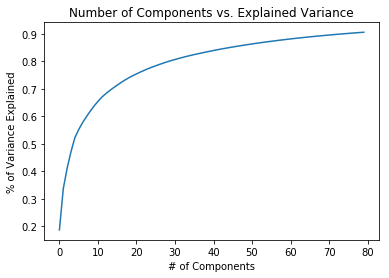

In [25]:
var_explained = pca.explained_variance_ratio_
plt.title("Number of Components vs. Explained Variance")
plt.xlabel("# of Components")
plt.ylabel("% of Variance Explained")
plt.plot(np.cumsum(var_explained))
print("Explained variance by", pca.n_components, "principal components:",
      np.cumsum(pca.explained_variance_ratio_)[pca.n_components-1])

# Visualizing the eigenfaces

In [26]:
# A helper function to make plots of the faces
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99,
                        top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

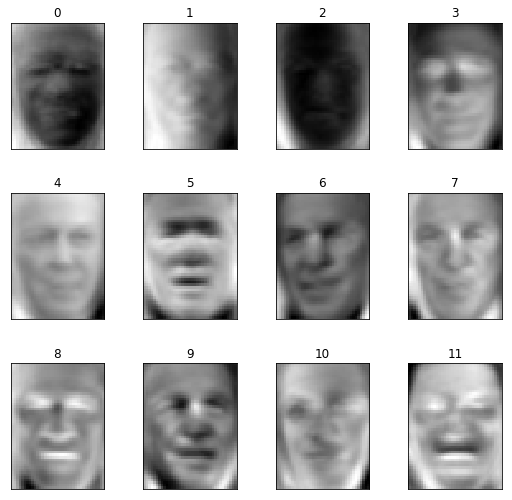

In [27]:
# Plot the gallery of the most significative eigenfaces
eigenface_titles = range(0, eigenfaces.shape[0])
 
plot_gallery(eigenfaces, eigenface_titles, h, w)
 
plt.show()

# Training a model

In [28]:
#Train a SVM classification model
 
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
 
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='auto'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs", (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in %0.3fs 8.401384115219116
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


# Model validation

In [29]:
#Quantitative evaluation of the model quality on the test set
#Validate the data
X_test_pca = pca.transform(X_test)
y_pred = clf.predict(X_test_pca)
 
print(classification_report(
    y_test, y_pred, target_names=target_names))
 
print('Confusion Matrix')
#Make a data frame so we can have some nice labels
cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
df = pd.DataFrame(cm, columns = target_names, index = target_names)
print(df)

                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.76      0.82        21
     Colin Powell       0.90      0.96      0.93        54
  Donald Rumsfeld       0.79      0.67      0.72        33
    George W Bush       0.84      0.96      0.90       125
Gerhard Schroeder       0.88      0.62      0.73        24
      Hugo Chavez       0.95      0.81      0.88        26
       Tony Blair       0.83      0.77      0.80        39

      avg / total       0.86      0.86      0.85       322

Confusion Matrix
                   Ariel Sharon  Colin Powell  Donald Rumsfeld  George W Bush  \
Ariel Sharon                 16             3                0              2   
Colin Powell                  0            52                0              2   
Donald Rumsfeld               1             0               22              9   
George W Bush                 1             0                3            120   
Gerhard Schroeder             0             

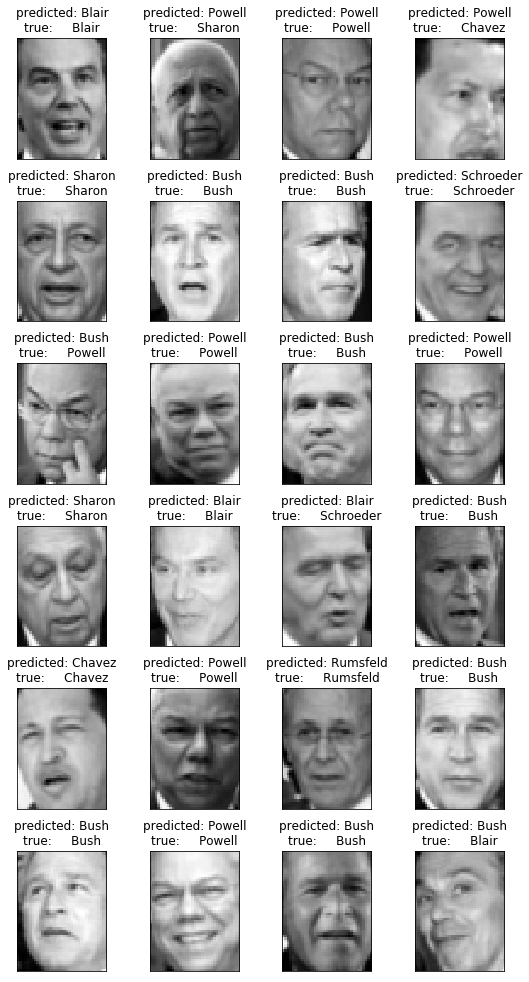

In [30]:
#Plot predictions on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, h, w, 6, 4)